## Python tutorial for openmm

This will contain a series of openmm scripts with detailed explanations - these simulations require the openmm package to be installed to run. <br />

Note: Since this notebook is likely being run in your local system - simulations here are only carried out for a limited number of steps and longer simulations should be run in SuperComputing Wales.

Current contents: <br />
1. Ensure openmm is installed and you have required files
2. First simulation - simple MD run (NVT) simulation
3. Second simulation - NPT simulation followed by the production run

##### Note: This notebook contains contents that are more conveniently imported from the python module *sw_openmm.py*. However, more detail on how openmm simulations operate 'behind the scenes' is included here. This notebook is not neccessary to using and understanding the python modules and tutorials in this repository, and is *no longer being updated*.

# 1. Ensure openmm is installed and you have required input files for parameterized systems

For the required input files, see jupyter notebooks "parametrization.ipynb" and "python_parameterizer.ipynb"

# 2. First simulation - simple MD run
This is the same script as found in the "parametrization.ipynb" openmm simulations are periodic by default.

In [1]:
# Note: This is a depreceated way of calling openmm, but it still calls the correct packages.
from simtk.openmm import app
import simtk.openmm as mm
from simtk import unit

In [2]:
import openmm

If you see any errors above it is necessary to install openmm into your python environment. I am using anaconda to manage my environments and when opening the terminal for my environment I ran the following command: <br />

```shell
conda install -c conda-forge openmm
```
After running this command in the anaconda terminal the import functions should run with no errors. (You may need to restart or relaunch the notebook for the changes to take effect).

This system that we will be running simulations for in this tutorial is a 3x3 array of 3HB monomers:
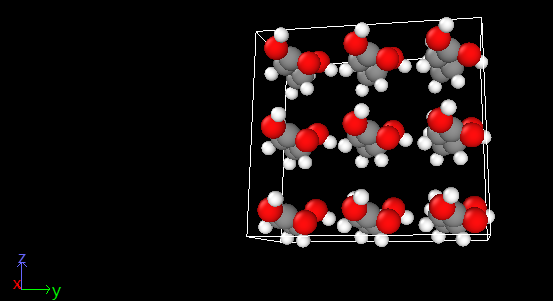
 <br />
 However, it is necessary to solvate these monomers in water:
 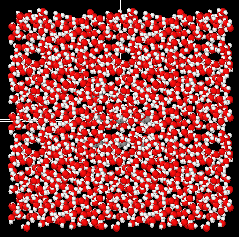
  <br />
 The cubic box is simply the array of monomers solvated in water.

In [5]:
# Load Amber files - if you cloned the github repository these files should load with no errors and are found 
#   in the same place as this notebook
prmtop = app.AmberPrmtopFile('pdb_files/systems/3HB_monomer_2_2_array/3HB_monomer_2_2_array.prmtop') # Topology file
inpcrd = app.AmberInpcrdFile('pdb_files/systems/3HB_monomer_2_2_array//3HB_monomer_2_2_array.rst7') # Coordinate file

Now we can create a system and intergrator object: <br />
- System
    - nonbondedMethod: This is the method for handling nonbonded interactions, here the Particle Mesh Ewald method is chosen (PME) and is a common method for describing long-range electrostatic interactions in MD simulations.
    - nonbondedCutoff: This is a cutoff distance for nonbonded interactions. i.e. If atoms are further than this distance apart (1nm) they will not interact with eachother.
    - constraints: This is where constraints are added to the system, this constraint (HBonds) makes sure no any bonds involving hydrogen are kept fixed, preventing flucutaution of these bonds during simulations.
- Integrator (temp, collision rate, integration time step)
    - Temperature: We can set the temperature in units of Kelvin.
    - Collision rate: The freqeuncy of which random collision forces are applied to particles in the system.
    - Time step: This is the integration time step and is the length of time between integration steps.

In [6]:
# Create system and integrator
system = prmtop.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1.0*unit.nanometers, constraints=app.HBonds)
integrator = mm.LangevinIntegrator(300*unit.kelvin, 1.0/unit.picoseconds, 2.0*unit.femtoseconds)

ValueError: Illegal nonbonded method for a non-periodic system

Now we have set up our system and integrator, we need to set up a simulation with the files we loaded (topology (prmtop file) and input coordinate "inpcrd" for short (rst7 file) and both the system and integrator.

In [ ]:
# Create simulation
simulation = app.Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)

The next step is to minimize the energy the enrgy of system and finds the local minimum energy of the system.

In [ ]:
# Minimize energy
simulation.minimizeEnergy()

The final step beofre running the simulation is assign the correct distribution of velocities to particles in our simulation. The Maxwell-Boltzmann distribution is used here generate velocities at the specified temperature. <br />

Note: The temperature at which velocities are set should be the same as the temperature set for the integrator.

In [ ]:
# Set initial velocities
simulation.context.setVelocitiesToTemperature(300*unit.kelvin)

No we can run our simulation and specify some reporters for out outputs.
- PDBReporter: This will generate a trajectory file for our simulation and we specify a (filename, intervals to record)
- StateDataReporter: This will generate a csv file containing important parameters from the simulation and we specify (filename , intervals to record, data to output)

And run the simulation by calling "simulation.step(number_of_steps)"

For the StateDataReporter, a list of different outputs we can record from our system are listed here: http://docs.openmm.org/7.0.0/api-python/generated/simtk.openmm.app.statedatareporter.StateDataReporter.html

In [ ]:
# Run simulation
# Note: this will not output anything, and instead the outputs are redirected to the specified files
simulation.reporters.append(app.PDBReporter('3HB_monomer_3_3_array_output.pdb', 1000))
simulation.reporters.append(app.StateDataReporter('3HB_monomer_3_3_array_data.csv', 1000, step=True, potentialEnergy=True, temperature=True))
#simulation.step(10000)


# 3. Second simulation - NPT simulation followed by the production run
## 3.1 NPT simulation
An NPT simulation is useful to equilibrate the system before running the final main simulation (this final simulation will be very similar to the first simulation carried out - but likely for many more steps). Equilibrating the system allows it to reach a non-fluctuating density. An addition in NPT simulations is a "barostat", this applies a pressure to the system and will allow it reach the correct density at the specified pressure.

Before running the simulation, an "initial_npt_simulation" function is defined below: <br />
- Filename: Uses the os module and split function to extract the name of the system - this will be used to name output files from this step.
- prmtop and inpcrd: This is set up the same way as before, but the filenames are passed to function instead of directly to the "prmtop" and "inpcrd" variables.
- System: Set up the same way as in the first simulation
- Barostat: A barostat allows us to control the pressure of a system during molecular dynamics simulations, the monte carlo barostat is used and uses the monte carlo method to adjust the volume of the simulation box.
- Integrator: This is set up in the same way as the first simulation.
- Simulation: The simulation is set up the same way as in the first simulation and initial velocities are also set the same way.
- Datareporters: In this simulation we will add some datareporters from the BCSW sw_openmm module.

In [ ]:
# To use the other datareporters from the BCSW module we need to import them - but we need to add the directory where they
#    are located to our python path so that they are callable.
import sys
sys.path.append('../../../../') # Add directory to python path - without this there will be an error that states this module cannot be found.

# Now you can import functions from the directory
from BCSW.modules.sw_openmm import DcdWriter, DataWriter

When importing the BCSW module I encountered an error:
```shell
no module called 'Parmed'
```

To install this module, open the anaconda navigator and the terminal associated to this environment and run this command:
```shell
conda install -c conda-forge parmed
```
After running this command in the anaconda terminal the import functions should run with no errors. (You may need to restart or relaunch the notebook for the changes to take effect).

In [ ]:
import os
# ARGUMENTS
# topoloogy_file: .prmtop file
# coordinate file: .rst7 file
# temp: temperature (as an integer)
# pressure: pressure (as an integer)
# total steps: total steps to run the simulation for (as an integer)
def initial_npt_simulation(topology_file, coordinate_file, temp, pressure, total_steps):
    # Get topology and coordinates from files
    filename = os.path.basename(topology_file).split('.')[0]
    prmtop = app.AmberPrmtopFile(topology_file) # Topology file
    inpcrd = app.AmberInpcrdFile(coordinate_file) # Coordinate file
    
    # Create system and integrator
    system = prmtop.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1.0*unit.nanometers, constraints=app.HBonds) 
    barostat = mm.MonteCarloBarostat((pressure*unit.atmosphere), (temp*unit.kelvin)) # Define barostat (pressure, temp)
    system.addForce(barostat) # Add the barostat to the system
    integrator = mm.LangevinIntegrator(300*unit.kelvin, 1.0/unit.picoseconds, 2.0*unit.femtoseconds)
    
    # Create simulation
    simulation = app.Simulation(prmtop.topology, system, integrator)
    simulation.context.setPositions(inpcrd.positions)
    
    # Set initial velocities
    simulation.context.setVelocitiesToTemperature(300*unit.kelvin)
    
    # Set up reporters
    # PDB trajectory - this is slighlty redundant with the addition of the DCD trajectory, but it is still useful for 
    #   visualisation of the system and coloring specific residues 
    output_pdbname = filename + "_" + str(pressure) + "_atm_traj.pdb"
    simulation.reporters.append(app.PDBReporter(output_pdbname, 1000))
    
    # DCD trajectory
    output_dcdname = filename + "_" + str(pressure) + "_atm_traj"
    dcdWriter = DcdWriter(output_dcdname, 1000)
    simulation.reporters.append(dcdWriter.dcdReporter)
    
    # Datawriter - This is a more complete data writer than previously used, the file generated is a comma delimited text file
    output_dataname = filename + "_" + str(pressure) + "_atm_data"
    dataWriter = DataWriter(output_dataname, 1000, total_steps)
    simulation.reporters.append(dataWriter.stateDataReporter)

    return(simulation)
# Note: this function will not run the simulation, but it will set everything up for one final step
# Note: this function is only usable if an NPT simulation is the first simulation run, in some cases an annealing step
#     precedes the NPT equilibration and a different function should be used - this will be created in due time.

In [ ]:
# Now we run the NPT simulation
total_steps = 100000 # Number of steps to run for
simulation = initial_npt_simulation('3HB_monomer_3_3_array.prmtop', '3HB_monomer_3_3_array.rst7', 300, 1, total_steps) # (topology file, coordinate file, temp, pressure, total steps - this is specifie din the line above)
simulation.step(total_steps) # Run the simulation

### 3.1 Graphing results

Now lets graph our results from the data file "3HB_monomer_3_3_array_1_atm_data.txt". We don't need to plot all of the data and will plot key parts of the system - potential energy, kinetci energy, total energy, temperature, box volume and density. For the equilibration to be succesful - we should see a convergence of density (in this case to a value around 1 g/ml as our system is mainly comprised of water and the simulation is run at 1 atm).

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Read data from your file
file_path = '3HB_monomer_3_3_array_1_atm_data.txt'  # Replace with the actual path
df = pd.read_csv(file_path, delimiter='\t')

# Exclude the last two columns
columns_to_plot = df.columns[3:-2]

# Calculate the number of rows and columns needed for subplots
num_rows = (len(columns_to_plot) + 1) // 2  # +1 to ensure an extra row if there's an odd number of columns
num_cols = min(2, len(columns_to_plot))  # Maximum of 2 columns in each row

# Set up subplots in the calculated arrangement
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))

# Plot each column against "Time (ps)" in a separate subplot
for i, column in enumerate(columns_to_plot):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].plot(df["Time (ps)"], df[column])
    axes[row, col].set_title(column)
    axes[row, col].set_xlabel("Time (ps)")
    axes[row, col].set_ylabel(column)
    axes[row, col].grid(True)

# Remove empty subplots if there are not enough columns to fill all slots
for i in range(len(columns_to_plot), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the layout to prevent clipping of the suptitle
plt.show()

## 3.2 Production run
Now we can move onto the final production run - which is an NVT simulation. i.e. Fixed temperature, box volume and number of particles. A "production run" is the name we give the final simulation of interest. <br />

To continue the simulation, we first need to get some key data from the NPT run. To do this, we need to retrieve the state of the simulations - with this we will have access to information such as and periodic box vectors.

Before running the simulation, an "production_run" function is defined below: <br />
- Filename: Uses the os module and split function to extract the name of the system - this will be used to name output files from this step.
- prmtop: This is set up the same way as in the "initial_npt_simulation" function - except we no longer rquire the initial coordinate file and instead retrieve our coordinates from the output of the NPT simulation.
- System: Set up the same way as in the first simulation
- Integrator: This is set up in the same way as the first simulation.
- Simulation: The simulation is set up the same way as in the first simulation and initial velocities are also set the same way.
- Datareporters: In this simulation we will add some datareporters from the BCSW sw_openmm module - they are named slighlty differently to the "initial_npt_simulation" function.

In [ ]:
import os
# ARGUMENTS
# topoloogy_file: .prmtop file
# simulation: the simulation object from a previous simulation
# temp: temperature (as an integer)
# total steps: total steps to run the simulation for (as an integer)
def production_run(topology_file, simulation, temp, total_steps):
    # Retrieve information from the simulation
    state = simulation.context.getState(getPositions=True, getEnergy=True) # Define state object 
    xyz = state.getPositions() # Obtain positions of the particles from previous step

    # Get topology from file
    filename = os.path.basename(topology_file).split('.')[0]
    prmtop = app.AmberPrmtopFile(topology_file) # Topology file
    
    # Create system and integrator 
    system = prmtop.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1.0*unit.nanometers, constraints=app.HBonds)
    integrator = mm.LangevinIntegrator(300*unit.kelvin, 1.0/unit.picoseconds, 2.0*unit.femtoseconds)
    
    # Create simulation
    simulation = app.Simulation(prmtop.topology, system, integrator)
    simulation.context.setPositions(xyz)
    
    # Set up reporters
    # PDB trajectory - this is slighlty redundant with the addition of the DCD trajectory, but it is still useful for 
    #   visualisation of the system and coloring specific residues 
    output_pdbname = filename + "_prod_traj.pdb"
    simulation.reporters.append(app.PDBReporter(output_pdbname, 1000))
    
    # DCD trajectory
    output_dcdname = filename + "_prod_traj"
    dcdWriter = DcdWriter(output_dcdname, 1000)
    simulation.reporters.append(dcdWriter.dcdReporter)
    
    # Datawriter - This is a more complete data writer than previously used, the file generated is a comma delimited text file
    output_dataname = filename + "_prod_data"
    dataWriter = DataWriter(output_dataname, 1000, total_steps)
    simulation.reporters.append(dataWriter.stateDataReporter)
    
    return(simulation)

#### Error running this simulation 
```shell
OpenMMException: Particle coordinate is NaN
```
This error occurs due to differences in the periodic box vecotrs. This happens as the .prmtop file specifies periodic box vectors but since we have equilibrated the system - we have extracted new periodic box vectors for a periodic system of a different size. <br />

Some more information about this error can be found at: https://github.com/openmm/openmm/wiki/Frequently-Asked-Questions#nan as sometimes there are other reasons for this error occuring.




In [ ]:
# Now we run the production run
total_steps = 100000 # Number of steps to run for
simulation = production_run('3HB_monomer_3_3_array.prmtop', simulation, 300, total_steps) # (topology file, coordinate file, temp, pressure, total steps - this is specifie din the line above)
simulation.step(total_steps) # Run the simulation

To fix this error we will update the function with some extra lines:
```shell
vx, vy, vz = state.getPeriodicBoxVectors() # Obtain periodc box vectors of the previous step
simulation.context.setPeriodicBoxVectors(vx, vy, vz) # Set these as the periodic box vectors
```
This will ensure our simulation is using periodic box vectors from the last stage of the simulation and not those specified in the .prmtop topology file. Now the simulation should run. 

In [ ]:
import os
# ARGUMENTS
# topoloogy_file: .prmtop file
# simulation: the simulation object from a previous simulation
# temp: temperature (as an integer)
# total steps: total steps to run the simulation for (as an integer)
def production_run(topology_file, simulation, temp, total_steps):
    # Retrieve information from the simulation
    state = simulation.context.getState(getPositions=True, getEnergy=True) # Define state object 
    xyz = state.getPositions() # Obtain positions of the particles from previous step
    vx, vy, vz = state.getPeriodicBoxVectors() # Obtain periodc box vectors of the previous step

    # Get topology from file
    filename = os.path.basename(topology_file).split('.')[0]
    prmtop = app.AmberPrmtopFile(topology_file) # Topology file
    
    # Create system and integrator 
    system = prmtop.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1.0*unit.nanometers, constraints=app.HBonds)
    integrator = mm.LangevinIntegrator(300*unit.kelvin, 1.0/unit.picoseconds, 2.0*unit.femtoseconds)
    
    # Create simulation
    simulation = app.Simulation(prmtop.topology, system, integrator)
    simulation.context.setPositions(xyz)
    simulation.context.setPeriodicBoxVectors(vx, vy, vz)
    
    # Set up reporters
    # PDB trajectory - this is slighlty redundant with the addition of the DCD trajectory, but it is still useful for 
    #   visualisation of the system and coloring specific residues 
    output_pdbname = filename + "_prod_traj.pdb"
    simulation.reporters.append(app.PDBReporter(output_pdbname, 1000))
    
    # DCD trajectory
    output_dcdname = filename + "_prod_traj"
    dcdWriter = DcdWriter(output_dcdname, 1000)
    simulation.reporters.append(dcdWriter.dcdReporter)
    
    # Datawriter - This is a more complete data writer than previously used, the file generated is a comma delimited text file
    output_dataname = filename + "_prod_data"
    dataWriter = DataWriter(output_dataname, 1000, total_steps)
    simulation.reporters.append(dataWriter.stateDataReporter)
    
    return(simulation)

In [ ]:
# Now we run the production run
total_steps = 100000 # Number of steps to run for
simulation = production_run('3HB_monomer_3_3_array.prmtop', simulation, 300, total_steps) # (topology file, coordinate file, temp, pressure, total steps - this is specifie din the line above)
simulation.step(total_steps) # Run the simulation

### 3.2 Graphing results

Now lets graph our results from the data file "3HB_monomer_3_3_array_prod_data.txt". We don't need to plot all of the data and will plot key parts of the system - potential energy, kinetci energy, total energy, temperature, box volume and density. In the production run (NVT) the density and box volume will be constant.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Read data from your file
file_path = '3HB_monomer_3_3_array_prod_data.txt'  # Replace with the actual path
df = pd.read_csv(file_path, delimiter='\t')

# Exclude the last two columns
columns_to_plot = df.columns[3:-2]

# Calculate the number of rows and columns needed for subplots
num_rows = (len(columns_to_plot) + 1) // 2  # +1 to ensure an extra row if there's an odd number of columns
num_cols = min(2, len(columns_to_plot))  # Maximum of 2 columns in each row

# Set up subplots in the calculated arrangement
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))

# Plot each column against "Time (ps)" in a separate subplot
for i, column in enumerate(columns_to_plot):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].plot(df["Time (ps)"], df[column])
    axes[row, col].set_title(column)
    axes[row, col].set_xlabel("Time (ps)")
    axes[row, col].set_ylabel(column)
    axes[row, col].grid(True)

# Remove empty subplots if there are not enough columns to fill all slots
for i in range(len(columns_to_plot), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the layout to prevent clipping of the suptitle
plt.show()

### 3.3 Analysing results

To analyse these results, we can use mdanalysis - that will be found in another notebook.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Read data from your file
file_path = 'C:/Users/danie/Swansea University/Francisco Martin-Martinez - York_Dan/05_Others/04_ResearchMaterial/BCSW/3HB_prod_data.txt'  # Replace with the actual path
df = pd.read_csv(file_path, delimiter=',')

# Exclude the last two columns
columns_to_plot = df.columns[3:-2]

# Calculate the number of rows and columns needed for subplots
num_rows = (len(columns_to_plot) + 1) // 2  # +1 to ensure an extra row if there's an odd number of columns
num_cols = min(2, len(columns_to_plot))  # Maximum of 2 columns in each row

# Set up subplots in the calculated arrangement
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))

# Plot each column against "Time (ps)" in a separate subplot
for i, column in enumerate(columns_to_plot):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].plot(df["Time (ps)"], df[column])
    axes[row, col].set_title(column)
    axes[row, col].set_xlabel("Time (ps)")
    axes[row, col].set_ylabel(column)
    axes[row, col].grid(True)

# Remove empty subplots if there are not enough columns to fill all slots
for i in range(len(columns_to_plot), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the layout to prevent clipping of the suptitle
plt.show()